# High Risk Counties Related to Opioid Prescribing
## by Chi Zhang

## Preliminary Wrangling

> The dataset contains county level data from CMS integrated with a variety of other federal government datasets. The goal is to identify the risk level of counties in terms of Opioid prescribing.

In [3]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [4]:
df = pd.read_excel("CMS_SDOH_County_Data.xlsx")

In [3]:
# high-level overview of data shape and composition
print(df.shape)
print(df.dtypes)

(15755, 78)
FIPS                               int64
year_num                           int64
All_Ages_in_Poverty_Universe     float64
All_ages_in_Poverty_Count_Est    float64
SDOH_All_ages_in_Poverty_Rate    float64
                                  ...   
Urban_Overall_Claims             float64
Urban_Part_D_Opioid_Prescribe    float64
Urban_Part_D_Prescribers         float64
target_LAOPR_80                    int64
target_LAOPR_90                    int64
Length: 78, dtype: object
   FIPS  year_num  All_Ages_in_Poverty_Universe  \
0  1001      2013                        547.62   
1  1001      2014                        549.03   
2  1001      2015                        548.60   
3  1001      2016                        549.39   
4  1001      2017                        550.21   
5  1003      2013                       1929.31   
6  1003      2014                       1974.14   
7  1003      2015                       2010.06   
8  1003      2016                       2058.42   
9

In [6]:
# change FIPS which is county id into categorical datatype
df['FIPS'] = df['FIPS'].astype(str) 

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15755 entries, 0 to 15754
Data columns (total 78 columns):
FIPS                               15755 non-null object
year_num                           15755 non-null int64
All_Ages_in_Poverty_Universe       15715 non-null float64
All_ages_in_Poverty_Count_Est      15715 non-null float64
SDOH_All_ages_in_Poverty_Rate      15715 non-null float64
SDOH_Median_Household_Income       15715 non-null float64
Opioids_Estimated_Age_adj          15705 non-null float64
Drug_poisoning_deaths              15709 non-null float64
SDOH_PMU                           15709 non-null float64
Actual_Per_Capita_Costs2           15716 non-null float64
Average_HCC_Score2                 15718 non-null float64
FFS_Beneficiaries                  15718 non-null float64
Hospital_Readmission_Rate2         15253 non-null float64
MA_Beneficiaries                   15382 non-null float64
MA_Participation_Rate2             15382 non-null float64
Standardized_Per_Capita_

There are three attributes that have null counts over 100, and they are SDOH_Physically_Unhealthy_Days_, SDOH_Mentally_Unhealthy_Days and SDOH_Violent_Crime_Rate

In [29]:
df.dropna().shape 

(12884, 78)

### What is the structure of your dataset?

> There are 78 attributes and 12884 complete rows in the dataset. All variables are numeric execpt for year, FIPS, and two target variables that are binary.

### What is/are the main feature(s) of interest in your dataset?

> The main features of interest can be target_LAOPR_80,Long_Acting_Opioid_Pres2 and Opioid_Prescribing_Rate2 which all indicate the risk level of counties in terms of Opioid use and prescribing. 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> I think poverty rate, employed rate and year will help support my investigation into the Opioid risk level of counties.

## Univariate Exploration

In [85]:
# First look at binary variable of interest: target_LAOPR_80
df['target_LAOPR_80'].value_counts()

0    12668
1     3087
Name: target_LAOPR_80, dtype: int64

The target binary variable has 3087 1s which is 20% of the total rows.

In [36]:
# Next we look at variable of interest: Long_Acting_Opioid_Pres2
# start with a standard-scaled plot
df.describe()['Long_Acting_Opioid_Pres2']

count    15393.000000
mean        11.069252
std          6.502358
min          0.000000
25%          6.360000
50%         10.890000
75%         15.390000
max         81.820000
Name: Long_Acting_Opioid_Pres2, dtype: float64

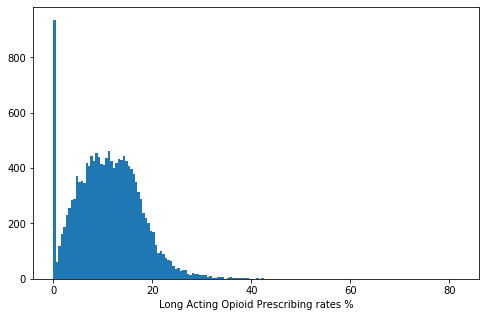

In [42]:
binsize = 0.5
bins = np.arange(0, df['Long_Acting_Opioid_Pres2'].max()+binsize, binsize)
plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'Long_Acting_Opioid_Pres2', bins = bins)
plt.xlabel('Long Acting Opioid Prescribing rates %')
plt.show()

The distribution of long acting opioid prescrbing rates follows a normal distributino with a tail to the right. There are outliers on the right, and a large number around 0. Next, We put the graph on a log scale. It's possible that some counties do not prescribe long lasting opioid and we can delete those since they are not exposed to any risk. 

In [45]:
df_not0 = df[df['Long_Acting_Opioid_Pres2'] != 0]
df_not0.describe()['Long_Acting_Opioid_Pres2']

count    14468.000000
mean        11.776956
std          6.053829
min          0.190000
25%          7.190000
50%         11.380000
75%         15.670000
max         81.820000
Name: Long_Acting_Opioid_Pres2, dtype: float64

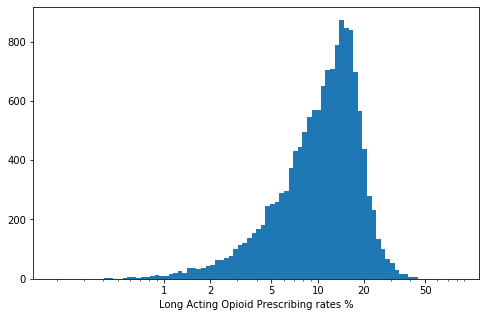

In [62]:
log_binsize = 0.03
bins = 10 ** np.arange(-0.72, np.log10(df_not0['Long_Acting_Opioid_Pres2'].max())+log_binsize, log_binsize)
plt.figure(figsize=[8, 5])
plt.hist(data = df_not0, x = 'Long_Acting_Opioid_Pres2', bins = bins)
plt.xscale('log')
plt.xticks([1, 2, 5, 10, 20, 50], [ 1, 2, 5, 10, 20, 50 ])
plt.xlabel('Long Acting Opioid Prescribing rates %')
plt.show()

Knowing that there are lots of counties on the lower end and few on the high end. The log transformed distribution looks roughly normal with a peak between 10 and 20.

In [57]:
# select outliers, using threshold of 40%
outliers = (df['Long_Acting_Opioid_Pres2'] > 40)
print(outliers.sum())
print(df.loc[outliers,:])

11
        FIPS  year_num  All_Ages_in_Poverty_Universe  \
1443    8079      2016                          7.30   
7693   29103      2016                         38.46   
8028   30007      2016                         56.84   
8029   30007      2017                         58.63   
8108   30039      2016                         33.38   
8363   31029      2016                         38.54   
8519   31091      2017                          6.50   
11938  46045      2016                         37.43   
11995  46069      2013                         13.51   
12095  46107      2013                         23.23   
14077  50009      2015                         61.42   

       All_ages_in_Poverty_Count_Est  SDOH_All_ages_in_Poverty_Rate  \
1443                            68.0                           9.30   
7693                           728.0                          18.90   
8028                           604.0                          10.60   
8029                           574.0    

There are 11 counties with long lasting opioid prescrbing rate higher than 40%, notice the rate is calculated by long lasting opioid claims divided by total claims. Question is why those 11 counties use much more long lasting opioid.

Next, we look at overall opioid prescribing rate

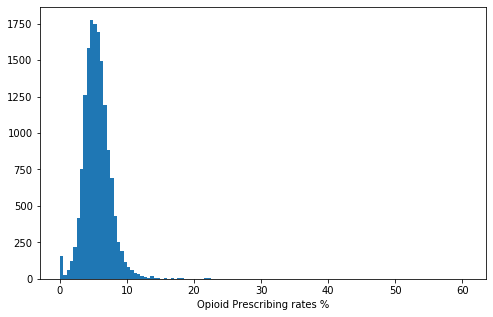

In [65]:
binsize = 0.5
bins = np.arange(0, df['Opioid_Prescribing_Rate2'].max()+binsize, binsize)
plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'Opioid_Prescribing_Rate2', bins = bins)
plt.xlabel('Opioid Prescribing rates %')
plt.show()

Similar to the long acting opioid rate, this one also has a tail to the right. Put it on log scale and check for 0 rates. 

In [66]:
df_not0 = df[df['Opioid_Prescribing_Rate2'] != 0]
df_not0.describe()['Opioid_Prescribing_Rate2']

count    15256.000000
mean         5.591584
std          2.202862
min          0.080000
25%          4.307500
50%          5.385000
75%          6.600000
max         60.260000
Name: Opioid_Prescribing_Rate2, dtype: float64

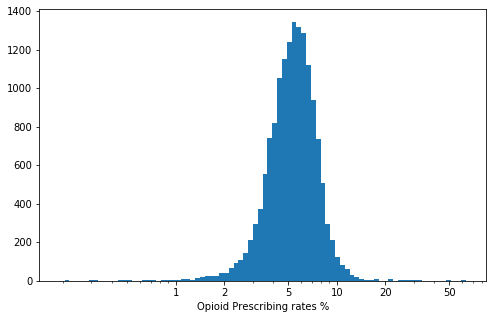

In [67]:
log_binsize = 0.03
bins = 10 ** np.arange(-0.72, np.log10(df_not0['Opioid_Prescribing_Rate2'].max())+log_binsize, log_binsize)
plt.figure(figsize=[8, 5])
plt.hist(data = df_not0, x = 'Opioid_Prescribing_Rate2', bins = bins)
plt.xscale('log')
plt.xticks([1, 2, 5, 10, 20, 50], [ 1, 2, 5, 10, 20, 50 ])
plt.xlabel('Opioid Prescribing rates %')
plt.show()

In [69]:
# select outliers, using threshold of 20%
Highrate = (df['Opioid_Prescribing_Rate2'] > 20)
print(Highrate.sum())
print(df.loc[Highrate,:])

28
        FIPS  year_num  All_Ages_in_Poverty_Universe  \
1290    8019      2013                         89.38   
1313    8027      2016                         44.43   
6900   27125      2013                         40.15   
6901   27125      2014                         40.02   
6902   27125      2015                         40.15   
6903   27125      2016                         39.66   
8206   30079      2014                         11.22   
8207   30079      2015                         11.34   
9153   35059      2016                         35.04   
9154   35059      2017                         34.98   
9654   37073      2017                        114.46   
12664  48009      2017                         87.54   
12951  48125      2014                         18.95   
12952  48125      2015                         18.82   
12953  48125      2016                         18.61   
12954  48125      2017                         18.85   
13225  48235      2013                       

This graph shows a normal distributnion with a peak around 5. There are 28 counties with rate higher than 20 and those can be consiered as high risk counties. 

Next, we look at the two programs that CMS has for beneficiaries: MA(Medicare Advantage) and FFS (Fee for Service)

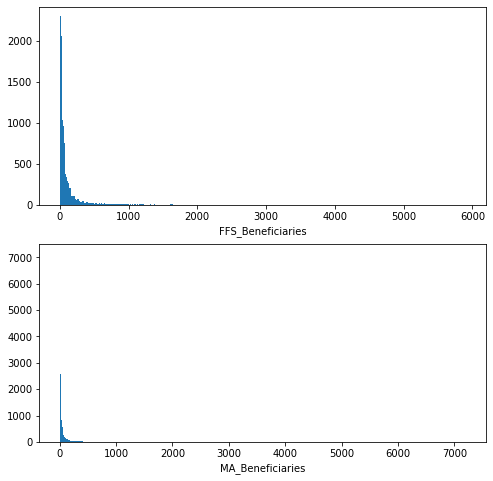

In [73]:
fig, ax = plt.subplots(nrows=2, figsize = [8,8])

programs = ['FFS_Beneficiaries', 'MA_Beneficiaries']
for i in range(len(programs)):
    var = programs[i]
    bins = np.arange(min(df[var]), max(df[var])+10, 10)
    ax[i].hist(data = df, x = var, bins = bins)
    ax[i].set_xlabel('{}'.format(var))

plt.show()

Now we change the bin size and zoom in

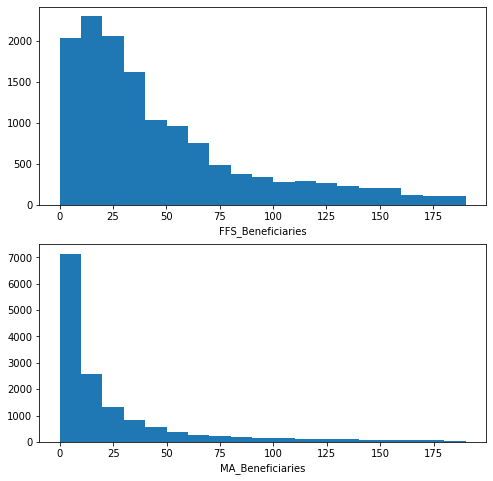

In [194]:
fig, ax = plt.subplots(nrows=2, figsize = [8,8])

programs = ['FFS_Beneficiaries', 'MA_Beneficiaries']
for i in range(len(programs)):
    var = programs[i]
    bins = np.arange(min(df[var]), 200, 10)
    ax[i].hist(data = df, x = var, bins = bins)
    ax[i].set_xlabel('{}'.format(var))

plt.show()

Both graphs have long tails, apply log transformation on x axis

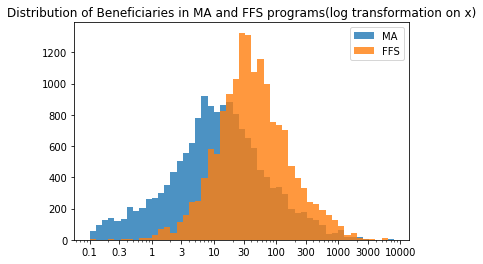

In [83]:
bins_edge = 10**np.arange(-1, np.log10(df["MA_Beneficiaries"].max())+0.1, 0.1)
plt.hist(df["MA_Beneficiaries"], bins = bins_edge, alpha = 0.8, label = 'MA')
plt.xscale('log')
tick_locs = [0.1, 0.3, 1, 3, 10,30,100,300,1000,3000,10000]
plt.xticks(tick_locs, tick_locs)
plt.title('Distribution of MA Beneficiaries(log trans)');
bins_edge = 10**np.arange(-1, np.log10(df["FFS_Beneficiaries"].max())+0.1, 0.1)
plt.hist(df["FFS_Beneficiaries"], bins = bins_edge, alpha = 0.8, label = 'FFS')
plt.xscale('log')
tick_locs = [0.1,0.3, 1,3, 10,30,100,300,1000,3000,10000]
plt.xticks(tick_locs, tick_locs)
plt.legend()
plt.title('Distribution of Beneficiaries in MA and FFS programs(log transformation on x)');

The log transformed distribution of the two shows that MA is more spread out with a peak around 10, whereas FFS has a peak around 30. FFS being on the right of MA shows that there are more beneficiaries enrolled in FFS than MA.

Next, we look at another predictor: poverty rate

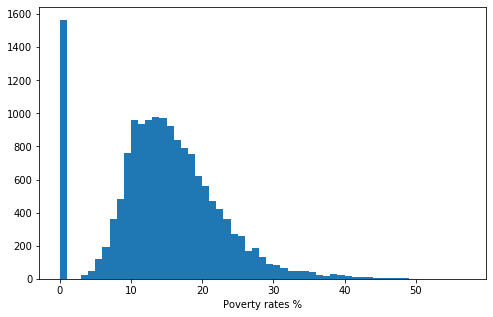

In [91]:
binsize = 1
bins = np.arange(0, df['SDOH_All_ages_in_Poverty_Rate'].max()+binsize, binsize)
plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'SDOH_All_ages_in_Poverty_Rate', bins = bins)
plt.xlabel('Poverty rates %')
plt.show()

The graph shows a number of counts around 0, and a long tail on the right. Thus, we look at the 0 ish cases and take log on x axis

In [108]:
cases = df[df['SDOH_All_ages_in_Poverty_Rate'] < 1]

In [110]:
cases[['All_ages_in_Poverty_Count_Est','All_Ages_in_Poverty_Universe','POP_ESTIMATE_2','SDOH_All_ages_in_Poverty_Rate']]

,All_ages_in_Poverty_Count_Est,All_Ages_in_Poverty_Universe,POP_ESTIMATE_2,SDOH_All_ages_in_Poverty_Rate
6,25696.0,1974.14,199189.0,0.13
12,7380.0,230.66,26294.0,0.32
31,4988.0,199.39,20343.0,0.25
37,22579.0,1127.27,115536.0,0.20
56,3293.0,131.70,13317.0,0.25
...,...,...,...,...
15701,1130.0,86.97,8772.0,0.13
15703,1031.0,85.72,8667.0,0.12
15719,4253.0,426.90,43547.0,0.10
15725,2515.0,209.28,20953.0,0.12


Based on the table, those records with poverty rate lower than 1 were miscalculated without multiplying by 100. To fix this issue, we need to recalculate poverty using poverty count estimate and population estimate.

In [7]:
df['SDOH_All_ages_in_Poverty_Rate'] = df['All_ages_in_Poverty_Count_Est']/df['POP_ESTIMATE_2']*100

In [112]:
df['SDOH_All_ages_in_Poverty_Rate'].describe()

count    15580.000000
mean        15.689624
std          5.968569
min          2.996259
25%         11.345132
50%         14.810898
75%         18.987066
max         56.535948
Name: SDOH_All_ages_in_Poverty_Rate, dtype: float64

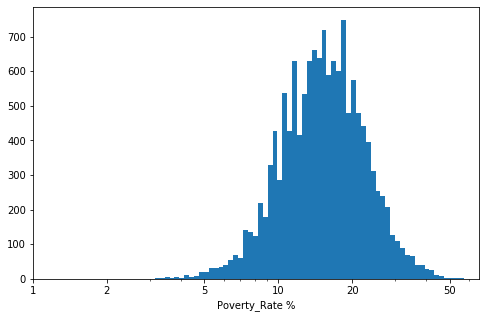

In [213]:
log_binsize = 0.02
bins = 10 ** np.arange(np.log10(df['SDOH_All_ages_in_Poverty_Rate'].min()), np.log10(df['SDOH_All_ages_in_Poverty_Rate'].max())+log_binsize, log_binsize)
plt.figure(figsize=[8, 5])
plt.hist(data = df_not0, x = 'SDOH_All_ages_in_Poverty_Rate', bins = bins)
plt.xscale('log')
plt.xticks([1, 2, 5, 10, 20, 50], [ 1, 2, 5, 10, 20, 50 ])
plt.xlabel('Poverty_Rate %')
plt.show()

After fixing the mistake and apply log tranformation, the distribtuion now has a center around 15.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Yes, there are cases when the distribution have outliers and long trails. I need to apply log transformation or zoom into a smaller range to show the distributions.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Yes, I found unusual distributions in poverty rates where rates around 0 have a large amount. It turns out that those rates were miscalculated, so I recalculate the rates and update the dataset. 

## Bivariate Exploration

In [121]:
#List of variables interesetd in exploring
numeric_vars = ['NET_MIG_', 'SDOH_All_ages_in_Poverty_Rate', 'FFS_Beneficiaries', 'MA_Beneficiaries', 'Long_Acting_Opioid_Pres2',
                'Opioid_Prescribing_Rate2', 'Total_Actual_Costs2']
categoric_vars = ['year_num']

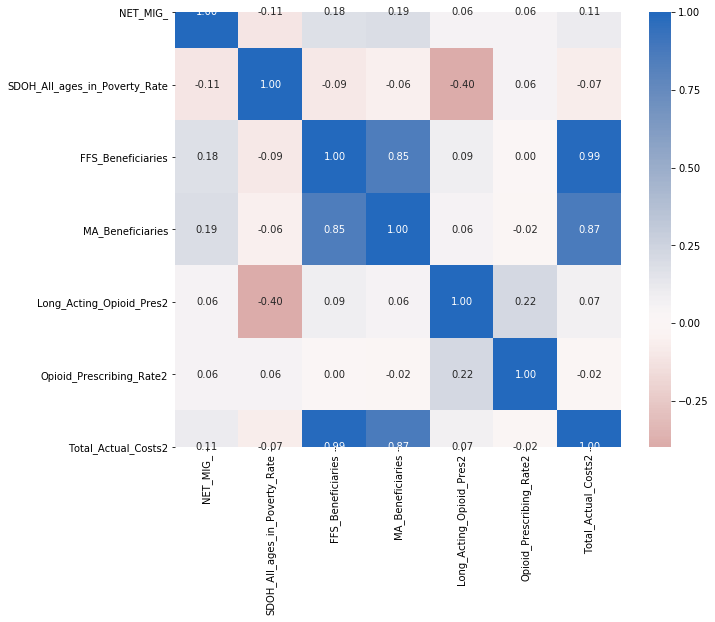

In [139]:
# correlation plot
plt.figure(figsize = [10, 8])
sb.heatmap(df[numeric_vars].corr(), annot = True, fmt = '.2f',
           cmap = 'vlag_r', center = 0)
plt.show()

C:\Users\Chi Zhang\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Chi Zhang\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


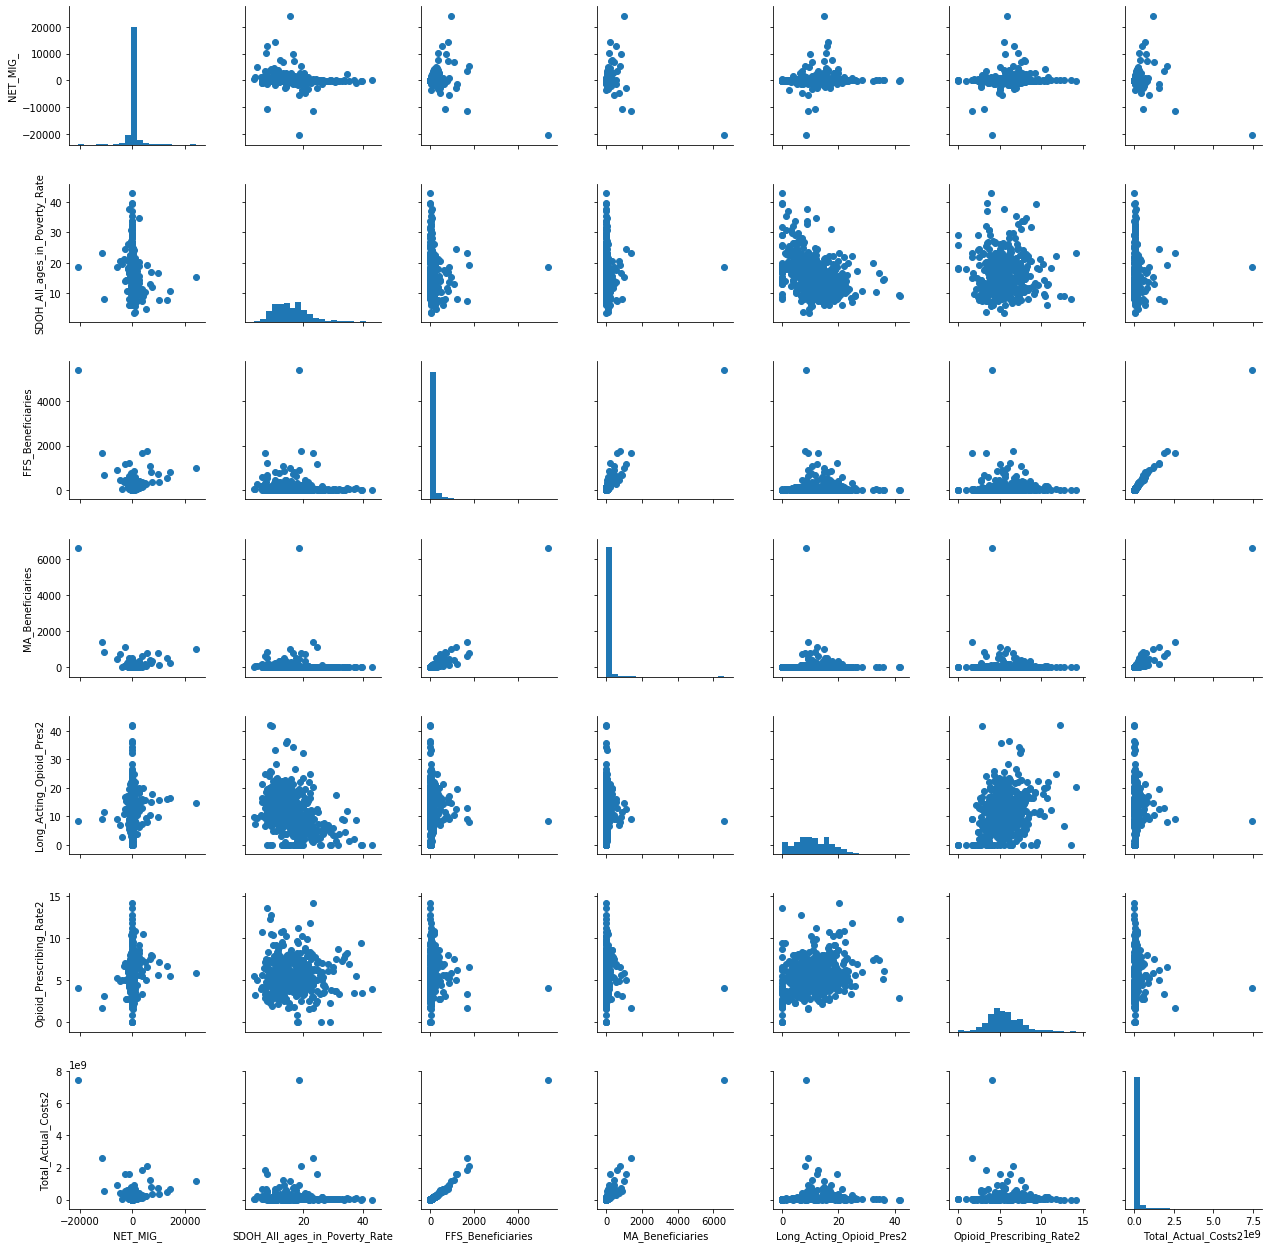

In [141]:
# plot matrix: sample 500 diamonds 
samples = np.random.choice(df.shape[0], 500, replace = False)
df_samp = df.loc[samples,:]

g = sb.PairGrid(data = df_samp, vars = numeric_vars)
g = g.map_diag(plt.hist, bins = 20);
g.map_offdiag(plt.scatter)

Not surprisingly, there is a strong correlation between number of beneficiaries of the two programs and totals costs for CMS. In addition, MA benes is positively correlated with FFS benes. What we did not expect is that long lasting opioid rate is negatively correlated with poverty, but overall opioid rate is not. 

Next we look at how our variables of interest change against years

<Figure size 720x720 with 0 Axes>

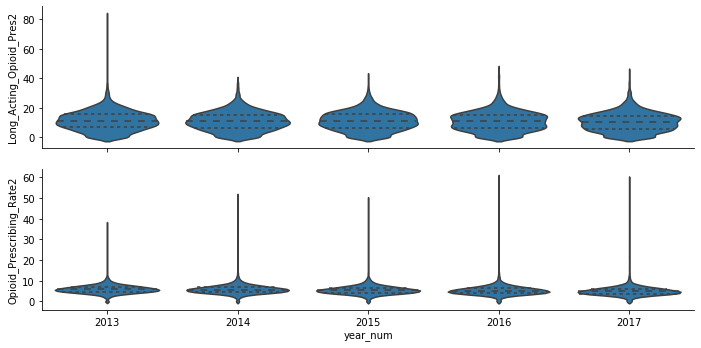

In [157]:
# samples = np.random.choice(diamonds.shape[0], 2000, replace = False)
# diamonds_samp = diamonds.loc[samples,:]

def violingrid(x, y, **kwargs):
    default_color = sb.color_palette()[0]
    sb.violinplot(x, y, color = default_color, inner = 'quartile')

plt.figure(figsize = [10, 10])
g = sb.PairGrid(data = df, y_vars = ['Long_Acting_Opioid_Pres2',
                'Opioid_Prescribing_Rate2'], x_vars = 'year_num', aspect = 4)
g.map(violingrid)
plt.show();

First, long acting has a wider spread compared to overall opioid rates. As the year gets close to 2017, more and more outlierswith high opioid prescribing rates appear which explains why opioid has become a risk factor recently. On the other hand, long acting opioid rates have not been changed significantly through out the years

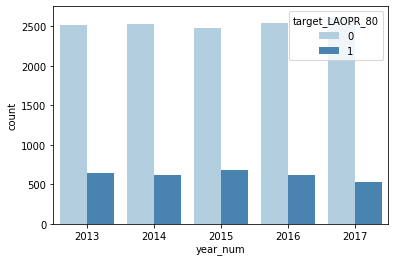

In [178]:
sb.countplot(data = df, x = 'year_num', hue = 'target_LAOPR_80', palette = 'Blues');

We use long acting opioid binary target to assess how number of high risk counties change over the years, and see that high risk counties have been slightly decreasing in recent years.

Now we will dig deeper into some of the relationships mentioned above

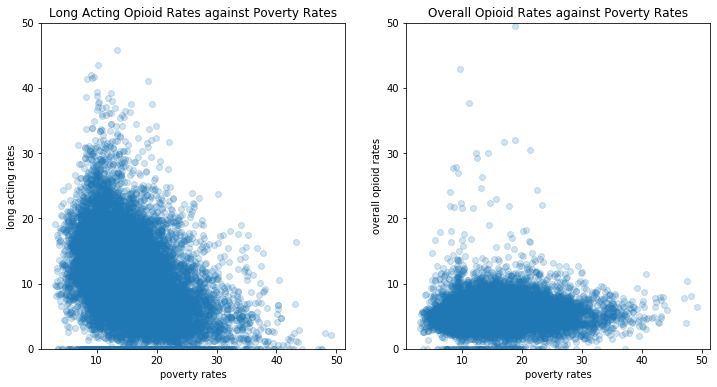

In [11]:
fig, ax = plt.subplots(ncols = 2, nrows = 1 , figsize = [12,6])
ax[0].scatter(data = df, x = 'SDOH_All_ages_in_Poverty_Rate', y = 'Long_Acting_Opioid_Pres2', alpha = 0.2)
ax[0].set_ylim([0, 50])
ax[0].set_xlabel('poverty rates')
ax[0].set_ylabel('long acting rates')
ax[0].set_title('Long Acting Opioid Rates against Poverty Rates')
ax[1].scatter(data = df, x = 'SDOH_All_ages_in_Poverty_Rate', y = 'Opioid_Prescribing_Rate2', alpha = 0.2)
ax[1].set_ylim([0, 50])
ax[1].set_xlabel('poverty rates')
ax[1].set_ylabel('overall opioid rates')
ax[1].set_title('Overall Opioid Rates against Poverty Rates')
plt.show()

Compared the two graphs above, long acting opioid rates decrease as poverty rate increases, but the overall opioid rates do not.

Next we look at feautures of total costs and number of beneficiaries.

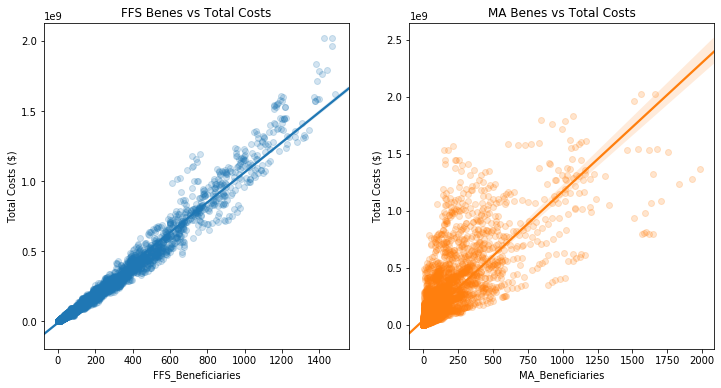

In [205]:
Bene_flag = (df['FFS_Beneficiaries'] <= 1500) & (df['MA_Beneficiaries'] <= 2000)
df_bene = df.loc[Bene_flag,:]
fig, ax = plt.subplots(ncols = 2, figsize = [12,6])
sb.regplot(data = df_bene, x = 'FFS_Beneficiaries', y = 'Total_Actual_Costs2', ax=ax[0], scatter_kws={'alpha':0.2})
ax[0].set_title('FFS Benes vs Total Costs')
ax[0].set_ylabel('Total Costs ($)')
sb.regplot(data = df_bene, x = 'MA_Beneficiaries', y = 'Total_Actual_Costs2', ax=ax[1],scatter_kws={'alpha':0.2})
ax[1].set_title('MA Benes vs Total Costs')
ax[1].set_ylabel('Total Costs ($)');

Both graphs have a strong positive correlation, however MA beneficiaries shows higher uncertainty indicating a higher risk.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

>  Long lasting opioid rate is negatively correlated with poverty, but overall opioid rate is not. Through out the five years timespan, long acting has a wider spread compared to overall opioid rates. As the year gets close to 2017, more and more outliers with high opioid prescribing rates appear.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> There is a strong correlation between number of beneficiaries of the two programs and totals costs for CMS with MA benes showing more uncertainty.

## Multivariate Exploration


In [19]:
df['log_long_rate'] = df['Long_Acting_Opioid_Pres2'].apply(np.log10)
df['log_poverty_rate'] = df['SDOH_All_ages_in_Poverty_Rate'].apply(np.log10)
df_mig = df[(df['NET_MIG_'] > 0) & (df['NET_MIG_'] < 5000)]

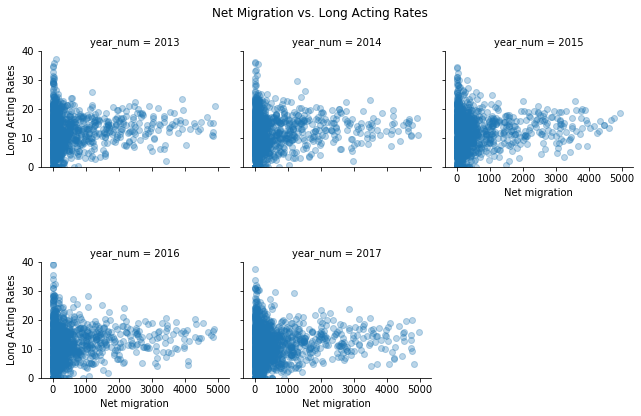

In [39]:
# create faceted heat maps through out the years
g = sb.FacetGrid(data = df_mig, col='year_num',col_wrap = 3,ylim = [0, 40])
plt.subplots_adjust(top=0.3)
g.fig.suptitle('Net Migration vs. Long Acting Rates')
g.map(plt.scatter,'NET_MIG_','Long_Acting_Opioid_Pres2',alpha = 0.3)
g.set_ylabels('Long Acting Rates')
g.set_xlabels('Net migration')
plt.show()

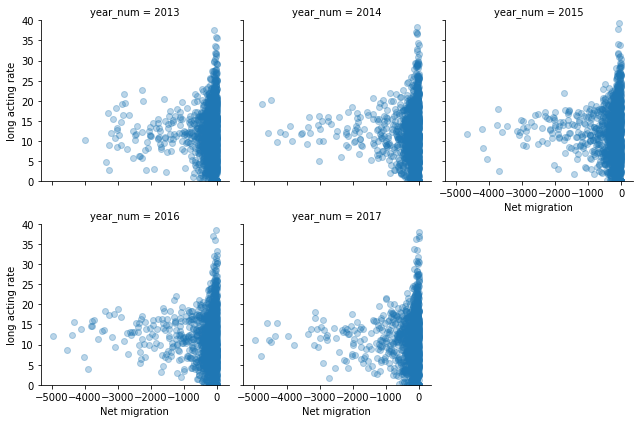

In [25]:
df_mign = df[(df['NET_MIG_'] < 0) & (df['NET_MIG_'] > -5000)]
g = sb.FacetGrid(data = df_mign, col='year_num',col_wrap = 3, ylim = [0, 40])
g.map(plt.scatter,'NET_MIG_','Long_Acting_Opioid_Pres2',alpha = 0.3)
g.set_ylabels('long acting rate')
g.set_xlabels('Net migration')
plt.show()

The graph between positive net migration and long acting rate shows that counties with large number of migrations tend to have long acting rates concentrated around 15.

<Figure size 432x288 with 0 Axes>

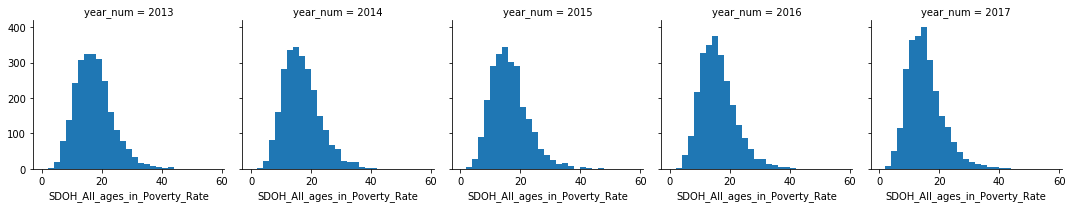

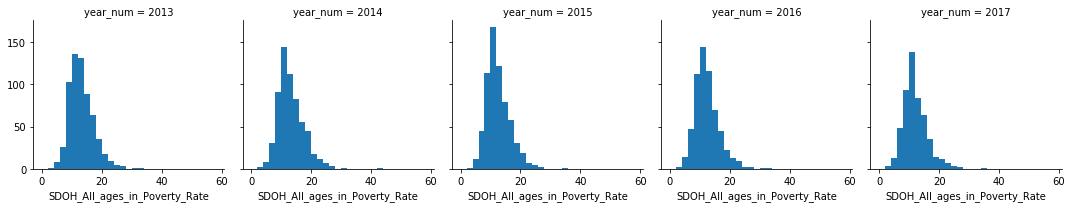

In [274]:
plt.figure()
g = sb.FacetGrid(data = df[df['target_LAOPR_80']==0], col = 'year_num',col_order = [2013,2014,2015,2016,2017])
bin_edges = np.arange(0, df['SDOH_All_ages_in_Poverty_Rate'].max()+2, 2)
g.map(plt.hist, 'SDOH_All_ages_in_Poverty_Rate',bins = bin_edges);
g = sb.FacetGrid(data = df[df['target_LAOPR_80']==1], col = 'year_num',col_order = [2013,2014,2015,2016,2017])
bin_edges = np.arange(0, df['SDOH_All_ages_in_Poverty_Rate'].max()+2, 2)
g.map(plt.hist, 'SDOH_All_ages_in_Poverty_Rate',bins = bin_edges);

Over the years, high risk counties have a relatively stable distrition in terms of poverty rates, whereas lower risk counties' poverty rates changing from a normal distribution to skewing to the right meaning that those counties have lowered their poverty rates significantly in the past 5 years.

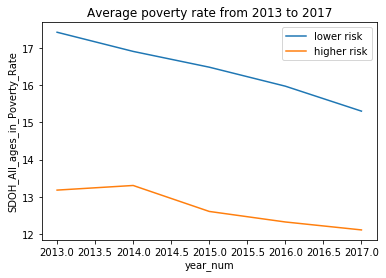

In [276]:
plt.figure()
temp1 = pd.DataFrame(df[df['target_LAOPR_80'] == 0].groupby('year_num').mean()['SDOH_All_ages_in_Poverty_Rate']).reset_index()
sb.lineplot(data = temp1, x = 'year_num' , y = 'SDOH_All_ages_in_Poverty_Rate', label = 'lower risk')
temp2 = pd.DataFrame(df[df['target_LAOPR_80'] == 1].groupby('year_num').mean()['SDOH_All_ages_in_Poverty_Rate']).reset_index()
sb.lineplot(data = temp2, x = 'year_num' , y = 'SDOH_All_ages_in_Poverty_Rate', label = 'higher risk')
plt.title('Average poverty rate from 2013 to 2017');

Then look at the average poverty for both risk groups. Lower risk counties's poverty rates have been decreasing at a faster rate to catch up to higher risk counties.

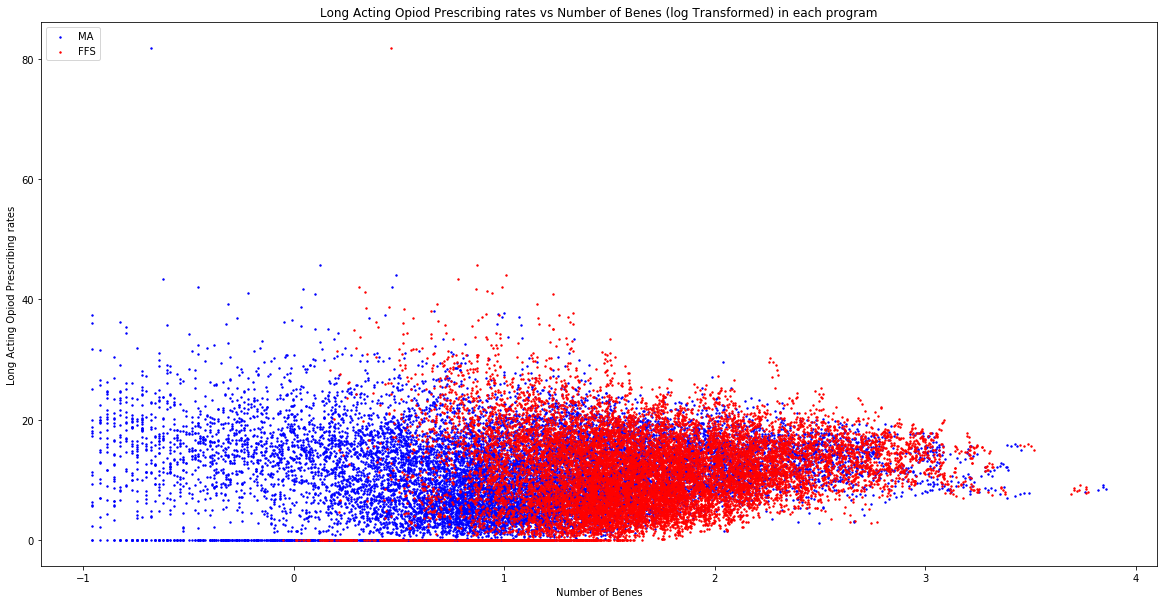

In [279]:
df['log_MA'] = df['MA_Beneficiaries'].apply(np.log10)
df['log_FFS'] = df['FFS_Beneficiaries'].apply(np.log10)
fig, ax1 = plt.subplots(figsize = [20,10])
ax1.scatter(df['log_MA'], df['Long_Acting_Opioid_Pres2'], s=2, c='b', label='MA')
ax1.scatter(df['log_FFS'], df['Long_Acting_Opioid_Pres2'], s=2, c='r', label='FFS')
plt.legend(loc='upper left')
plt.title('Long Acting Opiod Prescribing rates vs Number of Benes (log Transformed) in each program')
plt.ylabel('Long Acting Opiod Prescribing rates')
plt.xlabel('Number of Benes');

From the graph above, we do not see a clear correlation, next we use error bars to further explore the two binary groups

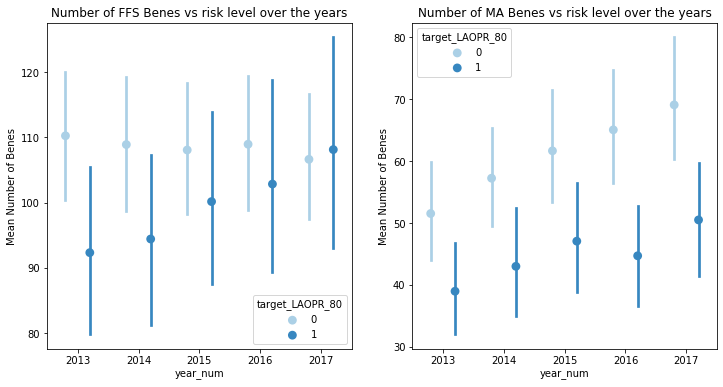

In [210]:
fig, ax = plt.subplots(ncols = 2, figsize = [12,6])
sb.pointplot(data = df, x = 'year_num', y = 'FFS_Beneficiaries', hue = 'target_LAOPR_80',
           palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[0])
ax[0].set_title('Number of FFS Benes vs risk level over the years')
ax[0].set_ylabel('Mean Number of Benes')
sb.pointplot(data = df, x = 'year_num', y = 'MA_Beneficiaries', hue = 'target_LAOPR_80',
           palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[1])
ax[1].set_title('Number of MA Benes vs risk level over the years')
ax[1].set_ylabel('Mean Number of Benes')
plt.show();

Over the years, FFS benes in high risk counties have been increasing to catch up to low risk counties. MA benes on the other hand, shows a gap between high risk and low risk counties, especially in 2016 and 2017.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Given the time series, Lower risk counties's poverty rates have been decreasing at a faster rate to catch up to higher risk counties. Also, FFS benes in high risk counties have been increasing to catch up to low risk counties. MA benes on the other hand, shows a gap between high risk and low risk counties, especially in 2016 and 2017.

### Were there any interesting or surprising interactions between features?

> Similar result in all five years, counties with large migration tend to have long acting rates concentrated between 10 to 20.